## Fully connected LSTM with PCA

#### Background

Since, we are predicting the future trajectory of a storm through time it makes the most sense if we use a neural network that suits sequential dataset. This has inspired us to use LSTM. The way the algorithm works is by converting the images(2D) into a 1 dimensional array, put it into the LSTM model and predict the next step and convert it back to the same 2D image. 

In the previous notebook, we have tried the fully connected LSTM without PCA, but the results weren't as good as with PCA, we suspect that this is due to LSTM not capturing the spatial information between the dataset.

Next, we have tried to use convolutional LSTM to capture the spatial information between the data and this has performed very well as well.

However, the Fully connected LSTM with PCA was able to capture sequential information as well and is more consistent and has a lower training time. Hence, we select Fully connected LSTM with PCA as our final model.

#### Loading the data

The way we load the data has been inspired by the nasa website. https://nbviewer.org/github/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-getting-started.ipynb
 
Before you get started please **load in all the .tar.gz** source and** train folder** into the current repository. Also To evaluate the actual SSIM and MSE metric at the end please upload 5 real images labelled as 
 
**"Real1.jpg", "Real2.jpg", "Real3.jpg", Real4.jpg", "Real5.jpg"**

## Installing Requirements

In [1]:
# Pre-installation
! pip install radiant-mlhub
! pip install livelossplot
! pip install pytorch-msssim
! pip install -q pycm livelossplot
%pylab inline
! pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We import all the required packages including the modules we have created in a folder called tools. (Note: importing in local machine and in colab is different because in google colab we cannot install our created module, but you can do this in a local environment. If you are running the notebook on colab, please mannually **load all python scripts** from **'tools'** folder first. )

In [2]:
import os  # noqa:E402 
import tarfile  # noqa:E402 


import numpy as np  # noqa:E402 
from livelossplot import PlotLosses  # noqa:E402 
import time  # noqa:E402 
# from pycm import *  # noqa:E402 

import torch  # noqa:E402 
import torch.nn as nn  # noqa:E402 
from torch.utils.data import TensorDataset, DataLoader  # noqa


import matplotlib.pyplot as plt  # noqa:E402 
import prettytable as pt  # noqa:E402 

# Importing team's Andrew module for local machine
# (after installing our modules) # noqa
# import tools.dataprocessing as dataprocessing
# import tools.visualisation as visualisation
# import tools.fc_lstm as fc_lstm
# import tools.fc_lstm_pca as fc_lstm_pca

# For colab it is not possible to setup the model,
# so we just load the py files directly
import dataprocessing as dataprocessing  # noqa:E402 
import visualisation as visualisation  # noqa:E402 
import fc_lstm as fc_lstm  # noqa:E402 
import fc_lstm_pca as fc_lstm_pca  # noqa:E402 
import metric as metric  # noqa:E402 

from sklearn.decomposition import PCA  # noqa:E402 

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Cuda installed! Running on GPU!
Cuda installed! Running on GPU!


## Downloading the dataset

Firstly, we have to paste the required .tar.gz file into the current directory, then we can run the cell below. This will extract all the tar.gz files

In [3]:
# unzip the dataset
for path, directories, files in os.walk('./'):
    for f in files:
        if f.endswith(".tar.gz"):
            tar = tarfile.open(os.path.join(path, f), 'r:gz')
            tar.extractall(path=path)
            tar.close()

We load the training data. Using the full dataset we add additional columns called file_name and images_per_storm. Originally, the images_per_storm column was used so that we could look at all the storms and filter the most interesting storm, but as we are performing this on the surprise data, there would be no need for the images_per_storm column.
More information of this function can be found in the docstrings(Andrew.pdf). We will split this data later on

## Data inspection

#### Load the data

Please modify the Load_data_to_train function and put the location of the tar.gz file an example is shown below

In [4]:
# Insert the tar.gz file into the current repository
# add the names of the source and label files below in the
# Load_data_to_train function
train_df = dataprocessing.Load_data_to_train("nasa_tropical_storm_competition_surprise_storm_source",  # noqa: E501
                                             "nasa_tropical_storm_competition_surprise_storm_labels",  # noqa: E501
                                             "./")  # noqa: E501
full_df = dataprocessing.manipdata_surprise(train_df)

In [5]:
full_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,file_name,images_per_storm
0,sss_001,sss,437401,1,120,./nasa_tropical_storm_competition_surprise_sto...,100
1,sss_002,sss,439200,1,121,./nasa_tropical_storm_competition_surprise_sto...,100
2,sss_003,sss,442800,1,124,./nasa_tropical_storm_competition_surprise_sto...,100
3,sss_004,sss,448200,1,128,./nasa_tropical_storm_competition_surprise_sto...,100
4,sss_005,sss,453600,1,130,./nasa_tropical_storm_competition_surprise_sto...,100


#### Inconsistency timesteps

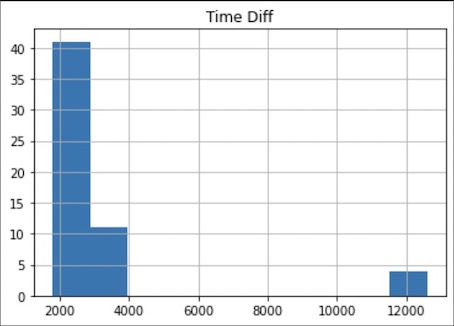

We can see in the previous dataset (competition) that the time difference of the images are not distributed evenly for some storms which this case causes the inconsistencies of the timestamp and there are some missing images of the storms. This coincides with the given data for the surprise storm as seen above.

In order to ensure the even distribution of our training set, we need to handle the inconsistency by generating and inserting some images accordingly(interpolating the images). However, the results wasn't improving and below shows train loss of when we have interpolated the data. 

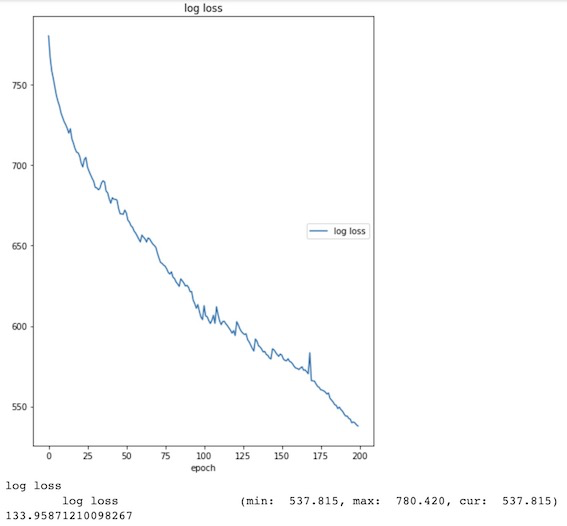

Hence we proceed, without data interpolation and more information of this can be found in the secondary notebook.

## Data processing

From here onwards, we will only look at the images instead of the label(wind speed), if given more time we could've added wind speed as another variable to improve our result. We still keep the wind speed data if we need it for further development

In [6]:
# Separating out windspeed from the dataframe
x_full = full_df.drop("Wind Speed", axis=1)
# Put the windspeed as a label
y_full = full_df['Wind Speed']

## Should we Normalize?

We have tried to trained our data without normalizing, however the training values were stocastic and didn't vary in a smooth manner, this could be due to exploding MSEs. Since our data isn't normalized. To see this, change the variable old_mean and old_std to the current mean and standard deviation of the dataset in order to standardize(see comments below)

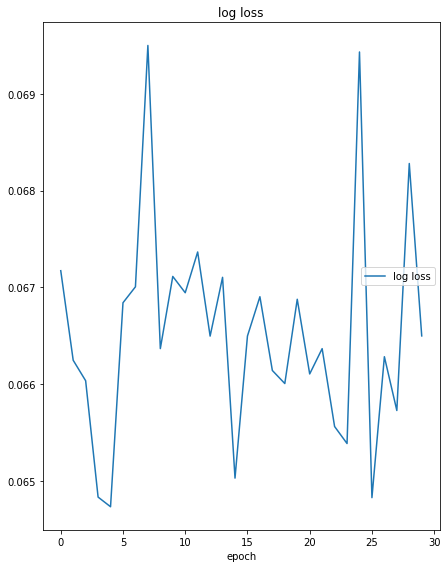

The way we turn the data into tensor, grayscale and normalize (if choose to) is inspired from this link

https://nbviewer.org/github/radiantearth/mlhub-tutorials/blob/main/notebooks/NASA%20Tropical%20Storm%20Wind%20Speed%20Challenge/nasa-tropical-storm-wind-speed-challenge-benchmark.ipynb

In [7]:
train_size = 95  # Choose training data size
val_size = 0  # Choose validation size
test_size = 5  # Choose testing size
old_mean = 0  # Remove this line if you want to normalize
old_std = 1  # Remove this line if you want to normalize

# Here we split,
# normalize with the previous mean and standard deviation,
# turn the data into the tensor,
full_dataset, train_dataset, val_dataset, test_dataset = dataprocessing.SplitData(x_full, y_full,  # noqa: E501
                                                                                  train_size,  # noqa: E501
                                                                                  val_size,  # noqa: E501  
                                                                                  test_size,  # noqa: E501
                                                                                  dataprocessing.DatasetSTORM,  # noqa: E501
                                                                                  old_mean,  # noqa: E501
                                                                                  old_std)  # noqa: E501

# Dataload our splitted data into a loader variable
full_loader = DataLoader(full_dataset, num_workers=0, batch_size=1)
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=1)
val_loader = DataLoader(val_dataset, num_workers=0, batch_size=1)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=1)

# Here we store the images in an array for the whole dataset, training, validation and testing    # noqa: E501
image_id_full, images_full, labels_full = dataprocessing.Loader_to_1D_array(full_loader, 366*366)    # noqa: E501
image_id, images, labels = dataprocessing.Loader_to_1D_array(train_loader, 366*366)    # noqa: E501
image_id_val, images_val, labels_val = dataprocessing.Loader_to_1D_array(val_loader, 366*366)    # noqa: E501
image_id_test, images_test, labels_test = dataprocessing.Loader_to_1D_array(test_loader, 366*366)    # noqa: E501

full data:  100 
Train_size:  95 
val_size: 0 
test_size:  6


We visualize the first few plots

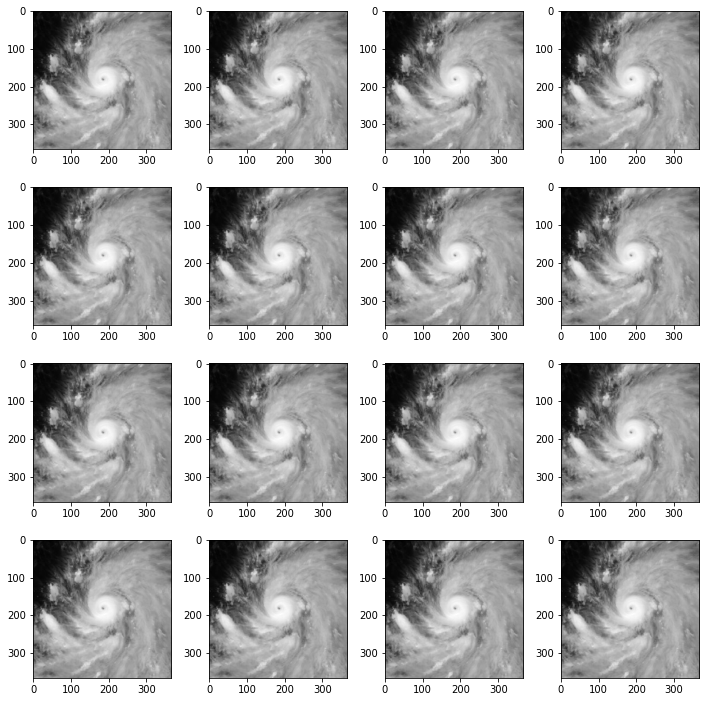

In [8]:
for image in full_loader:
    visualisation.show_batch(image, 4, 4)
    break

## Train PCA

We train the pca and transform our data inorder to be inserted into our network again. Please modify the number of principle components depending on the amount of data you use to train. In this particular case 93 is the best value.

In [9]:
# Reshaping the images for PCA
train_image = torch.stack(images)
test_image = torch.stack(images_test)
train_pca = train_image.reshape(-1, 366*366)
test_pca = test_image.reshape(-1, 366*366)
# train_image.shape

# Training the PCA and reducing the dimension of the dataset
pca_train = PCA(n_components=93)
pca_train_dataset = pca_train.fit_transform(train_pca)
pca_test_dataset = pca_train.transform(test_pca)
print("explained variance: ", sum(pca_train.explained_variance_ratio_))

# Putting the data in the required format
pca_train_data = torch.from_numpy(pca_train_dataset).float()
pca_test_data = torch.from_numpy(pca_test_dataset).float()

# Generating the training and testing set like previously
training, labeling = dataprocessing.create_inout_seq_pca(pca_train_data, 1)
testing, labeling_test = dataprocessing.create_inout_seq_pca(pca_test_data, 1)

storm_train = TensorDataset(training, labeling)
storm_test = TensorDataset(testing, labeling_test)

explained variance:  0.9993289857843587


## Grid Search
We perform grid search inorder to select the best hyperparameter between learning rate and the number of hidden layer. 

Here we choose to tune parameters including `learning rate` and `hidden layers`. 

The main point is that there is usually no rule for the number of hidden nodes you should use, it is something you have to figure out for each case by trial and error. The number of layers and cells required in an LSTM might depend on several aspects of the problem: The complexity of the dataset, such as the number of features, the number of data points, etc.

The `learning rate` is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.





In [10]:
# grid search
lr_range = [0.001, 0.01]
hidden_layers = [100, 500, 700, 1000]
loss_table = np.zeros((len(hidden_layers), len(lr_range)))
epochs = 100

# fixed prameters
fc_lstm.set_seed(42)
batch_size = 1
criterion = nn.MSELoss()

train_loader = DataLoader(storm_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(storm_test,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)


for i in range(len(hidden_layers)):
    for j in range(len(lr_range)):
        model_grid = fc_lstm.LSTM(93, hidden_layers[i], 93).to(device)  # noqa: E501
        optimizer = torch.optim.Adam(model_grid.parameters(), lr=lr_range[j])  # noqa: E501

        # liveloss = PlotLosses()
        start = time.time()
        for k in range(epochs):
            # logs = {}
            train_loss = fc_lstm.train_lstm_mse(model_grid,
                                                optimizer,
                                                criterion,
                                                train_loader)

        loss_table[i][j] = train_loss.item()
        end = time.time()
        print("finish!", hidden_layers[i], lr_range[j], loss_table[i][j], end - start)  #noqa:E501

finish! 100 0.001 2.868533134460449 14.99483323097229
finish! 100 0.01 1.4821640253067017 14.795194149017334
finish! 500 0.001 0.013766507618129253 14.811534881591797
finish! 500 0.01 1.0145264863967896 14.909445524215698
finish! 700 0.001 0.03718702495098114 14.84889554977417
finish! 700 0.01 1.4056850671768188 14.845307111740112
finish! 1000 0.001 0.06208275631070137 17.88580560684204
finish! 1000 0.01 2.796987295150757 17.305801153182983


In [11]:
# define head
head = [" hidden-layer | learnning rate ", 0.001, 0.01]

# change format for printing
loss_table = loss_table.tolist()
loss_table[0] = np.append(hidden_layers[0], loss_table[0])
loss_table[1] = np.append(hidden_layers[1], loss_table[1])
loss_table[2] = np.append(hidden_layers[2], loss_table[2])
loss_table[3] = np.append(hidden_layers[3], loss_table[3])
print("Grid Search table of loss: \n")

loss_t = pt.PrettyTable()
loss_t.field_names = head
loss_t.add_row(loss_table[0])
loss_t.add_row(loss_table[1])
loss_t.add_row(loss_table[2])
loss_t.add_row(loss_table[3])
print(loss_t)

Grid Search table of loss: 

+---------------------------------+----------------------+--------------------+
|  hidden-layer | learnning rate  |        0.001         |        0.01        |
+---------------------------------+----------------------+--------------------+
|              100.0              |  2.868533134460449   | 1.4821640253067017 |
|              500.0              | 0.013766507618129253 | 1.0145264863967896 |
|              700.0              | 0.03718702495098114  | 1.4056850671768188 |
|              1000.0             | 0.06208275631070137  | 2.796987295150757  |
+---------------------------------+----------------------+--------------------+


As we can view from the results, `learning rate = 0.001` and `hidden layer = 500` absolutely give us the best loss in the training process. So finally, we decide to set this two hyperparameters for training our best model.

Here we see that the optimal number of hidden layer is 500 with a learning rate of 0.001. Also, We decided to use 100 epochs to avoid overfitting

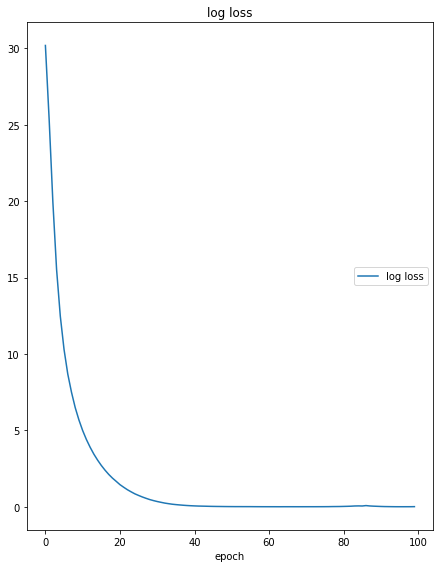

log loss
	log loss         	 (min:    0.005, max:   30.195, cur:    0.011)
37.330843448638916


In [17]:
fc_lstm.set_seed(42)
epochs = 100
batch_size = 1
model_LSTM_PCA = fc_lstm.LSTM(93, 500, 93).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM_PCA.parameters(), lr=0.001)
train_loader = DataLoader(storm_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(storm_test,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)

liveloss = PlotLosses()
start = time.time()
for i in range(epochs):
    logs = {}
    train_loss = fc_lstm.train_lstm_mse(model_LSTM_PCA,
                                        optimizer, criterion,
                                        train_loader)
    # Additional line for giving logs in liveloss plot
    logs['' + 'log loss'] = train_loss.item()

    # validation_loss= validate(model, criterion, val_loader)
    # # Additional line for giving logs in liveloss plot
    # logs['val_' + 'log loss'] = validation_loss.item()

    liveloss.update(logs)
    liveloss.draw()

end = time.time()
print(end - start)
# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

Our curve is much smoother than training with fully connected LSTM without PCA

Our prediction

torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])
torch.Size([93])


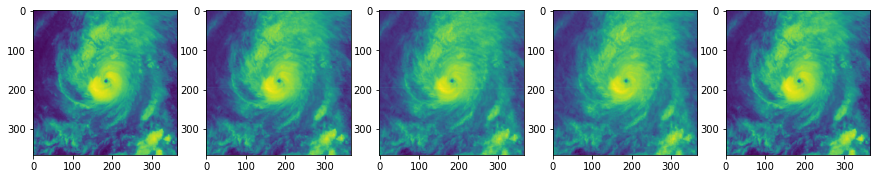

In [18]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
y_pred_LSTM_PCA, ys = fc_lstm_pca.evaluate_pca(model_LSTM_PCA,
                                               test_loader,
                                               pca_train)
y_pred_LSTM_PCA = y_pred_LSTM_PCA.reshape(5, 366, 366)
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(y_pred_LSTM_PCA[i-1])
plt.show()

Our image captures the edges better now and our structure looks more similar to the actual image as seen below

Actual Image

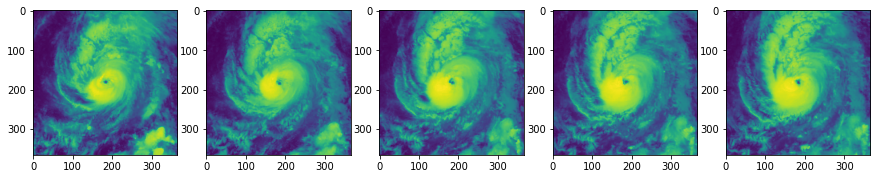

In [19]:
current = 94
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 1
for i in range(1, columns*rows + 1):
    img = images_full[current+i:current+i+1][0].reshape(366, 366)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [20]:
ssim_arr, mse_arr = metric.Generate_ssim_mse(y_pred_LSTM_PCA, "Real")

96 th image ssim:  0.4872346596880114 MSE 431.45254411896445
97 th image ssim:  0.34910431207370823 MSE 1149.5636179043865
98 th image ssim:  0.3445333503469539 MSE 1315.1063856788796
99 th image ssim:  0.33431463611668555 MSE 1498.370218579235
100 th image ssim:  0.31375130342817786 MSE 1800.784981635761


We see that as we predict further generally, our MSE would increase. This make sense because we are using our predicted result to predict the next result.